**1. Import dataset TESS (Toronto
Emotional Speech Set)**

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/kerja_praktik/data/dataverse_files

Mounted at /content/drive
/content/drive/MyDrive/kerja_praktik/data/dataverse_files


In [2]:
pwd

'/content/drive/MyDrive/kerja_praktik/data/dataverse_files'

**2. Import library**

In [3]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import os
import pandas as pd
import glob
import re
import numpy as np
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.models import Model, Sequential
from keras.layers import Flatten, Dense, Dropout, Activation


**3. Pembuatan dataframe**

Membuat kerangka data dari file dalam dataset

In [4]:
df = pd.DataFrame(columns=["Path", "Age", "Emotion", "Class"])
for file in glob.glob("*.wav"):
  age = re.findall("YAF|OAF",file)
  emotion = re.findall("[_][a-z]*", file)[1][1:]
  if age == "OAF":
    age = "Old"
    category = "Old and "+emotion
  else:
    age = "Young"
    category = "Young and "+emotion
  df = df.append({"Path":file,"Age":age,"Emotion":emotion,"Class":category},ignore_index=True)

**4. Penampilan Dataframe**

In [5]:
df

,Path,Age,Emotion,Class
0,YAF_hate_sad.wav,Young,sad,Young and sad
1,YAF_hate_happy.wav,Young,happy,Young and happy
2,YAF_have_angry.wav,Young,angry,Young and angry
3,YAF_hate_disgust.wav,Young,disgust,Young and disgust
4,YAF_hate_fear.wav,Young,fear,Young and fear
...,...,...,...,...
2795,OAF_note_ps.wav,Young,ps,Young and ps
2796,OAF_numb_angry.wav,Young,angry,Young and angry
2797,OAF_note_happy.wav,Young,happy,Young and happy
2798,OAF_pad_ps.wav,Young,ps,Young and ps


**5. Visualisasi Audio**

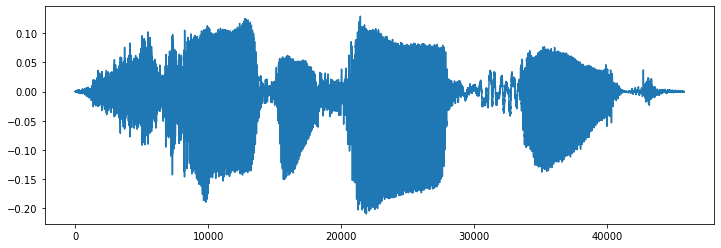

In [7]:
audio_file_path = df.iloc[0]["Path"]
librosa_audio_data, librosa_sample_rate = librosa.load(audio_file_path)

plt.figure(figsize =(12, 4))
plt. plot(librosa_audio_data)

**6.  Ekstraksi fitur Menggunakan MFCC**

In [11]:
def features_extractor(file):
  audio, sample_rate = librosa.load(file, res_type='kaiser_fast')
  mfccs_features =  librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
  mfccs_scaled_features = np.mean(mfccs_features.T, axis=0)
  return mfccs_scaled_features

**7. Menampilkan Hasil Ekstraksi Fitur**

In [12]:
df["Features"] = df["Path"].apply(lambda x: features_extractor(x))
df

,Path,Age,Emotion,Class,Features
0,YAF_hate_sad.wav,Young,sad,Young and sad,"[-391.1976, 75.03542, 26.406994, 54.580017, -1..."
1,YAF_hate_happy.wav,Young,happy,Young and happy,"[-334.76834, 27.482906, -18.22981, 40.16122, -..."
2,YAF_have_angry.wav,Young,angry,Young and angry,"[-363.4726, 38.388786, -22.96723, 14.2116375, ..."
3,YAF_hate_disgust.wav,Young,disgust,Young and disgust,"[-399.9477, 58.068954, -4.536504, 38.875675, -..."
4,YAF_hate_fear.wav,Young,fear,Young and fear,"[-300.7868, 37.027794, -19.649448, 40.014153, ..."
...,...,...,...,...,...
2795,OAF_note_ps.wav,Young,ps,Young and ps,"[-400.21423, 94.2405, 9.166524, 4.3233533, -10..."
2796,OAF_numb_angry.wav,Young,angry,Young and angry,"[-405.33694, 56.203655, -10.647553, -8.656308,..."
2797,OAF_note_happy.wav,Young,happy,Young and happy,"[-458.64355, 102.08481, 17.465755, -0.74126035..."
2798,OAF_pad_ps.wav,Young,ps,Young and ps,"[-364.96844, 72.935326, 1.404976, -1.4725207, ..."


**8. Label Encoding**

Label encoding digunakan untuk mengubah label yang berbentuk kategorikal menjadi numerik. Dimana angka 1 untuk yang berumur muda dan angka 0 untuk yang berumur tua.

In [14]:
X = np.array(df["Features"].to_list())
y = df["Class"].values
encoder = LabelEncoder()
y = to_categorical(encoder.fit_transform(y))
y

array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 1., 0., 0.]], dtype=float32)

**9. Normalisasi Array**

Membagi Dataset menjadi Data Testing dan Training

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

**10. Membuat model dan summary model**

In [16]:
# Creating a sequential model
model = Sequential()

# Adding a dense layer of 100 neurons
model.add(Dense(100))

# Applying rectified linear unit activation function
model.add(Activation('relu'))

# Applying dropout with probability of 0.2
model.add(Dropout(0.2))
model.add(Flatten())

# Adding a dense layer of 7 neurons
model.add(Dense(7))

# Applying 'softmax' activation
model.add(Activation('softmax'))

**11. Compile model**

Kompilasi model dengan '*categorical_crossentropy*' sebagai loss dan 'rmsprop' sebagai pengoptimal.

In [17]:
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='rmsprop')

**12. Train model**

Menggunakan 100 epoch dalam melatih model.

In [19]:
num_epochs = 100
num_batch_size = 64
# Fitting the model
history = model.fit(X_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(X_test, y_test))

Epoch 1/100
33/33 [==============================] - 1s 8ms/step - loss: 30.4997 - accuracy: 0.1952 - val_loss: 3.3275 - val_accuracy: 0.5486
Epoch 2/100
33/33 [==============================] - 0s 3ms/step - loss: 16.1740 - accuracy: 0.3224 - val_loss: 1.7026 - val_accuracy: 0.7271
Epoch 3/100
33/33 [==============================] - 0s 3ms/step - loss: 9.0989 - accuracy: 0.4886 - val_loss: 0.5951 - val_accuracy: 0.8557
Epoch 4/100
33/33 [==============================] - 0s 3ms/step - loss: 4.8739 - accuracy: 0.6181 - val_loss: 0.2760 - val_accuracy: 0.9171
Epoch 5/100
33/33 [==============================] - 0s 3ms/step - loss: 2.7512 - accuracy: 0.7248 - val_loss: 0.2199 - val_accuracy: 0.9443
Epoch 6/100
33/33 [==============================] - 0s 2ms/step - loss: 1.4997 - accuracy: 0.7943 - val_loss: 0.1560 - val_accuracy: 0.9586
Epoch 7/100
33/33 [==============================] - 0s 4ms/step - loss: 0.8241 - accuracy: 0.8581 - val_loss: 0.1085 - val_accuracy: 0.9571
Epoch 8/100

**13. Menghitung akurasi model**

In [20]:
scores = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {scores[1]*100}")

22/22 [==============================] - 0s 1ms/step - loss: 0.0154 - accuracy: 0.9971
Test Accuracy: 99.71428513526917


**14. Menampilkan plot**

[]

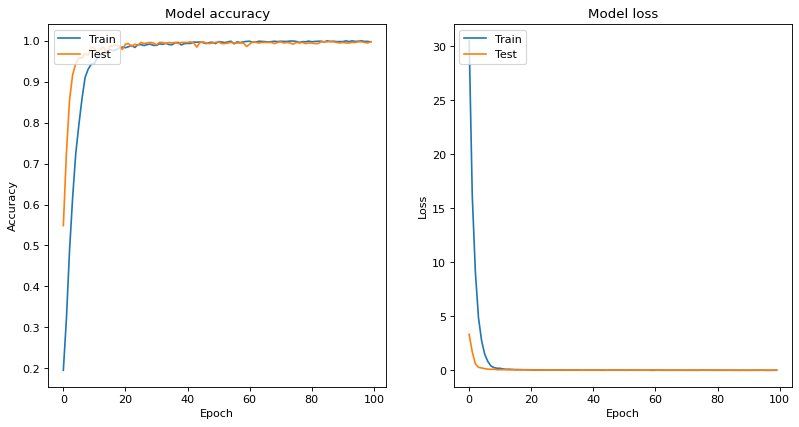

In [21]:
# Visualizing the loss and accuracy
plt.figure(figsize=(12,6), dpi=80)

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.plot()

plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.plot()

**15. Confusion matriks**

In [29]:
import seaborn as sns
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import LabelBinarizer

model_ANN = confusion_matrix(np.argmax(y_test, axis=1), model_predicted)
np.set_printoptions(precision=2)
print(model_ANN)
plt.figure()
ax = plt.subplot()
sns.heatmap(model_ANN, annot=True, ax=ax)

ax.set_xlabel('Predict labels')
ax.set_title('Confusion matrix')

NameError: ignored

**16. ROC (Receiver Operating Characteristics)**

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test.ravel(), model_pred.ravel())
auc_ = auc(fpr,tpr)

plt.figure(1)
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr, tpr, label='ROC (area - {:.3f})'.format(auc_))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legen(loc='best')
plt.show()

**17. Classification repot**

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))